In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import os
import scipy
sys.path.append(r'C:\Users\acostamendoza\projects\Grid-orientation-project\src')
from src.GridMetrics import *
import json
from skimage.feature import peak_local_max
%load_ext autoreload
%autoreload 2

In [2]:
# set matplotlib params
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

In [3]:
results_folder = r'C:\Users\acostamendoza\projects\Grid-orientation-project\results\r12\ratemaps'

rat = 'r1'
mod = '2'

G, general_results_working_directory, session_results_directory = load_grid_metrics_from_pickle(rat, mod)

with open(general_results_working_directory + '/' + rat + mod + '/' + rat + mod + '_odds-even-30s-no-rejection.json') as f:
    cell_trial_dict = json.load(f)

Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r12 already exists


In [4]:
def get_spacing_from_ratemap(cell, plot = False):
    
    ratemap = G.Scorer.calculate_ratemap(cell = cell)
    ratemap = np.nan_to_num(ratemap)
    
    ratemap_smooth = scipy.ndimage.gaussian_filter(ratemap, sigma = 1.5)
    
    # find local maxima
    coordinates = peak_local_max(ratemap_smooth, min_distance=5, num_peaks = 4, threshold_rel = 0.15)
    
    # pick the highest value and the two closer to it
    
    coordinates = coordinates[0:3]
    x = np.linspace(-1, 1, 50)
    y = np.linspace(-1, 1, 50)
    
    coord_xy = np.zeros((len(coordinates), 2))
    for i, coord in enumerate(coordinates):
        coord_xy[i, 0] = x[coord[0]]
        coord_xy[i, 1] = y[coord[1]]
        
    coord_xy = coord_xy[np.argsort(np.linalg.norm(coord_xy, axis = 1))]
    coord_xy = coord_xy[0:3]
    # find all distances of the coordinates to every other coordinate
    distances = np.zeros((len(coordinates), len(coordinates)))
    for i in range(0, len(coordinates)):
        for j in range(0, len(coordinates)):
            distances[i, j] = np.linalg.norm(coord_xy[i] - coord_xy[j])
    
    distances = np.triu(distances, k = 1)
    distances = distances[distances != 0].flatten()
    
    # check minimum distance and remove those distances that are more than 50% higher
    distances = distances[distances < np.min(distances) * 1.5]
    
    spacing = np.mean(distances)

    if plot:
        
        fig, ax = plt.subplots(1, 1, figsize = (5, 5))
        ax.pcolor(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50), ratemap_smooth, cmap = 'jet')
        ax.scatter(coord_xy[:, 1], coord_xy[:, 0], linewidth = 1, s = 100, c = 'white', edgecolor = 'black')
        
        # get the coord_xy closer to the origin
        coord_xy = coord_xy[np.argsort(np.linalg.norm(coord_xy, axis = 1))]
        # coord_xy = coord_xy[0:3]
        coord_xy = np.vstack((coord_xy, coord_xy[0]))
        ax.plot(coord_xy[:, 1], coord_xy[:, 0], c = 'black')
        ax.set_aspect('equal')
        ax.axis('off')
        # set tile
        ax.set_title('Cell ' + str(cell), fontsize = 16)
    
    return 100*spacing

Spacing of cell 146: 68.43826334143345
Spacing of cell 16: 85.62591141624917


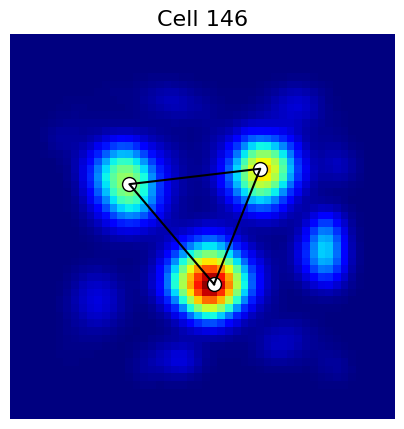

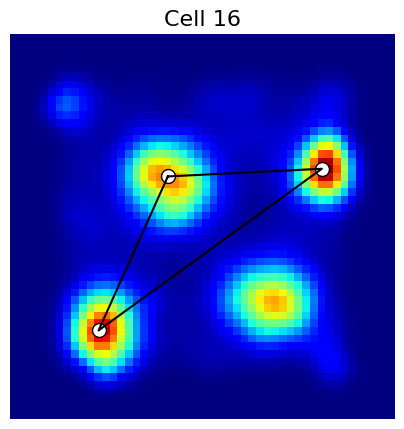

In [6]:
# get the spacing of all good cells and save them
spacing = get_spacing_from_ratemap(146, plot = True)
print('Spacing of cell 146:', spacing)

spacing = get_spacing_from_ratemap(16, plot = True)
print('Spacing of cell 16:', spacing)

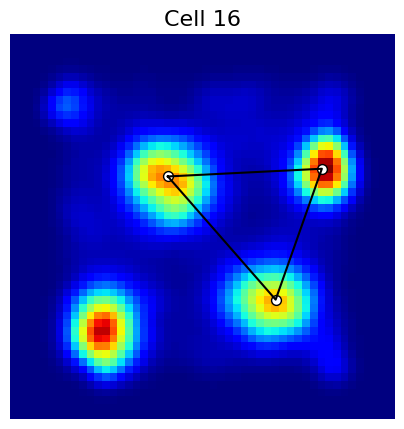

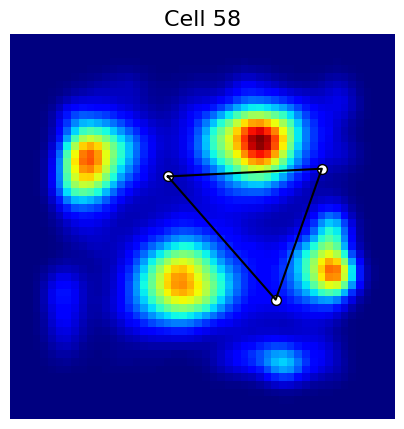

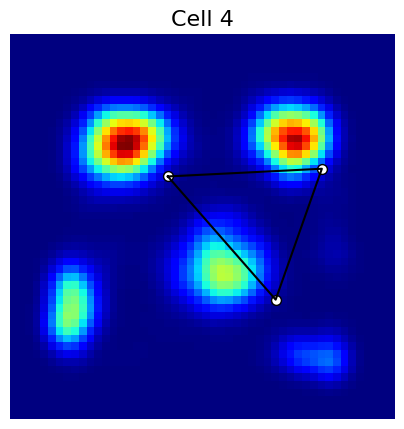

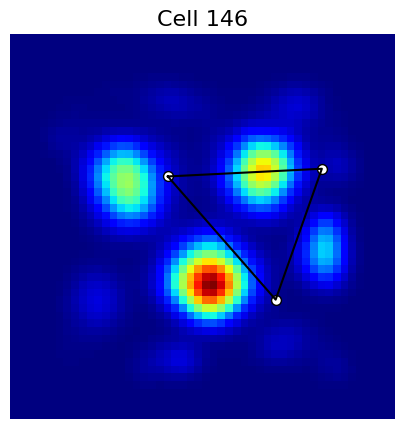

In [132]:
cells = [16, 58, 4, 146]

for cell in cells:
    
    ratemap = G.Scorer.calculate_ratemap(cell = cell)
    ratemap = np.nan_to_num(ratemap)
    ratemap_smooth = scipy.ndimage.gaussian_filter(ratemap, sigma = 1.5)
    
    spacing, coord_xy = get_spacing_from_ratemap(cell = 16, plot = False)
    
    # get the coord_xy closer to the origin
    coord_xy = coord_xy[np.argsort(np.linalg.norm(coord_xy, axis = 1))]
    
    # get the two closest coordinates
    coord_xy = coord_xy[0:3]
    
    fig, ax = plt.subplots(1, 1, figsize = (5, 5))
    ax.pcolor(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50), ratemap_smooth, cmap = 'jet')
    ax.scatter(coord_xy[:, 1], coord_xy[:, 0], linewidth = 1, s = 50, c = 'white', edgecolor = 'black')
    
    coord_xy = np.vstack((coord_xy, coord_xy[0]))
    ax.plot(coord_xy[:, 1], coord_xy[:, 0], c = 'black')
    ax.set_aspect('equal')
    ax.axis('off')
    # set tile
    ax.set_title('Cell ' + str(cell), fontsize = 16)

In [8]:
# get the spacing for all cells
r_ratemap = []
r_sac = []
cell_id = []
results_folder = r'C:\Users\acostamendoza\Box\grid-cell-project\sup-ratemap-analysis'

for cell in cell_trial_dict:
    
    none_trials = 0
    for trial in cell_trial_dict[cell]:
        if cell_trial_dict[cell][trial]['spacing_odd'] is None:
            none_trials += 1
        elif cell_trial_dict[cell][trial]['spacing_even'] is None:
            none_trials += 1
            
    if none_trials <= 5:
        cell_id.append(cell)
        r_ratemap.append(get_spacing_from_ratemap(cell = int(cell), plot = False))
        sac = G.Scorer.calculate_sac(cell = int(cell))
        r,_,_ = G.get_spacing_orientation_and_score(sac)
        r_sac.append(r)
        # plt.savefig(results_folder + '/cell_' + cell + '_ratemap.png', dpi = 300)
        # # save as svg too
        # plt.savefig(results_folder + '/cell_' + cell + '_ratemap.svg', dpi = 1200)
        # plt.close()

C:\Users\acostamendoza\projects\Grid-orientation-project\src\GridMetrics.py:225: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


In [154]:
print(r_sac)

[89.88863487977646, 87.84178995887572, 84.61230778157544, 80.68636144085217, 87.84178995887572, 85.12364164889857, 91.68270606538393, 91.98937836254282, 85.19800405895892, 83.73131964903719, 85.19800405895892, 83.20076905823139, 84.41849263028199, 85.12364164889857, 92.52796471396042, 91.8043266922591, 89.7648208034718, 82.29480407869801, 76.5138812604157, 88.72350351823215, 92.03575310680593, 94.75415670108468, 83.53662439694762, 82.29480407869801, 86.0609575556313, 91.68270606538393, 86.13317511391368, 84.23554985411425, 83.34280924565417, 91.68798115775235, 88.02684162915946, 85.19800405895892, 81.62522453635755, 87.84178995887572, 82.51519363400752, 81.10323933077318, 81.90408501290275, 85.81183354482208, 89.11867990758911, 84.61230778157544, 86.0886651516493, 92.15103973024517, 92.03575310680593, 88.94067981311355, 78.91700176768488, 87.65972897968109, 86.10396903849228, 95.41040393261216, 88.15914584603716, 72.68869535596588, 82.60923403151935, 88.15914584603716, 74.3009058720303

slope: 0.7934545953795674
intercept: 14.961976851948847
r_value: 0.7334072250411892
p_value: 4.668873791424164e-15
std_err: 0.08222547501211716


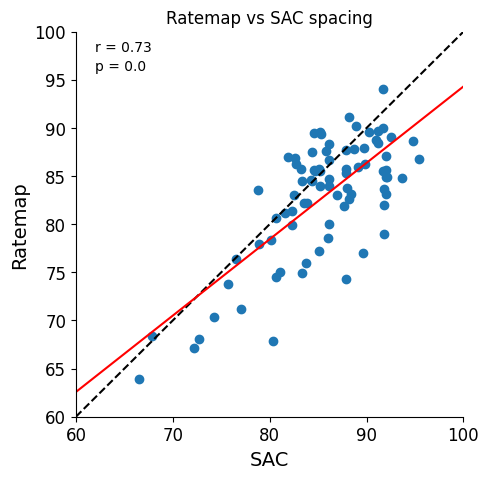

In [9]:
# make a figure of one plot vs the other
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.scatter(r_sac, r_ratemap)
# set same limits for both axes
# for both axes show values from 0.6 to 1
ax.set_xlim(60, 100)
ax.set_ylim(60, 100)
# draw a line from 60 to 100
ax.plot([60, 100], [60, 100], 'k--')
ax.set_xlabel('SAC')
ax.set_ylabel('Ratemap')
ax.set_title('Ratemap vs SAC spacing')

# fit a line to the data using linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_sac, r_ratemap)
x = np.linspace(60, 100, 100)
y = slope * x + intercept
ax.plot(x, y, 'r')

print('slope:', slope)
print('intercept:', intercept)
print('r_value:', r_value)
print('p_value:', p_value)
print('std_err:', std_err)

# set all labels to fontsize 14
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# # show the fitting parameters (p and r
ax.text(0.05, 0.95, 'r = ' + str(np.round(r_value, 2)), transform=ax.transAxes)
ax.text(0.05, 0.9, 'p = ' + str(np.round(p_value, 2)), transform=ax.transAxes)

# savefig to results folder
plt.savefig(results_folder + '/ratemap_vs_sac_spacing.png', dpi = 300)
# save as svg too
plt.savefig(results_folder + '/ratemap_vs_sac_spacing.svg', dpi = 1200)

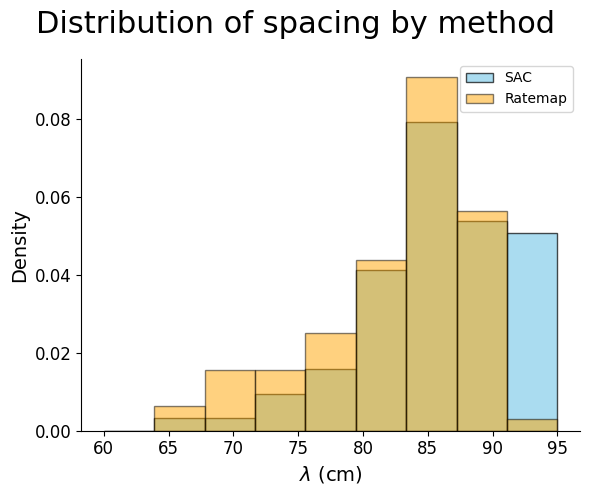

In [10]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
bins = np.linspace(60, 95, 10)

# increase space with title
fig.subplots_adjust(top=0.85)
fig.suptitle('Distribution of spacing by method', fontsize=22)

# Plot histogram for the original data
axes.hist(r_sac, bins=bins, color='skyblue', edgecolor='black', density = True, alpha = 0.7, label = 'SAC')
axes.hist(r_ratemap, bins=bins, color='orange', edgecolor='black', density = True, alpha = 0.5, label = 'Ratemap')
axes.set_xlabel(r'$\lambda$ (cm)')
axes.set_ylabel('Density')
axes.legend()

# set all labels to fontsize 14
ax = axes
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()

# savefig to results folder
plt.savefig(results_folder + '/ratemap_vs_sac_spacing_hist.png', dpi = 300)
# save as svg too
plt.savefig(results_folder + '/ratemap_vs_sac_spacing_hist.svg', dpi = 1200)